# Synthetic Data Generation

We will use a pre-tuned model to produce data. The model output should be a 3D array with condition, signaling node and time point for dimensions. The model output will be sub-sampled to produce the synthetic dataset.

In [1]:
import torch
import numpy
import LEMBAS_generator.bionetwork as bionetwork
import LEMBAS_generator.activationFunctions as activationFunctions
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from scipy.stats import pearsonr

## Run the pre-trained model

Run pre-trained model to produce synthetic data that are going to be used to evaluate the toy model. We will store both `fullYfull` which is the Y for all model states as well as the `X` that we used.

Prepare `X` and `fullYFull` for sub-sampling. `X` should be a matrix with Drug and Cell line as indexes and Targeted genes as columns. `fullYFull` should be matrix with Drug, Cell line, and Gene as indexes and Time points as columns.

The Cell line is also simulated by randomizing the bias randomly for each cell line and then run the model.

In [ ]:
# Setup parameters
N = 100
inputAmplitude = 3
projectionAmplitude = 1.2
seed = 123
torch.manual_seed(seed)
numpy.random.seed(seed)

# Cell type spliting parameters
n_celllines = 6
celltype_percent = 0.0
split_1 = 2
split_2 = 2
split_3 = 2

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('data/KEGGnet-Model.tsv')
annotation = pandas.read_csv('data/KEGGnet-Annotation.tsv', sep='\t')
bionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

synthetic_data_combined = []
X_combined = []
b_celltype = pandas.DataFrame()

# Generate input drug data
torch.manual_seed(123)
X = torch.zeros(N, len(inName), dtype=torch.double)
for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
    X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
    X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)
        
# Generate data for 6 different cell lines
cnt = 0  # cell line counter
# Generate first gen
for j in range(split_1):
    celltype = cnt
    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = None)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

    Y, YfullRef, fullYFull, b_celltype_array_1 = parameterizedModel(X)
    # Generate second gen
    for k in range(split_2):
        celltype = cnt
        parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = b_celltype_array_1)
        parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

        Y, YfullRef, fullYFull, b_celltype_array_2 = parameterizedModel(X)
        # Generate third gen
        for l in range(split_3):
            cell_line_name = f"CL_{cnt}"
            celltype = cnt
            parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = b_celltype_array_2)
            parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

            Y, YfullRef, fullYFull, b_celltype_array = parameterizedModel(X)
            fullYFull = fullYFull.detach()

            # Transform fullYFull to a dataframe
            fullYFull_np = fullYFull.numpy()  # dimensions: conditions, node names, states

            dim1, dim2, dim3 = fullYFull_np.shape

            reshaped_array = fullYFull_np.reshape(dim1 * dim2, dim3)

            synthetic_data = pandas.DataFrame(reshaped_array)

            #drug_names = [f"D_{i}" for i in range(1, dim1 + 1)]
            drug_names = ['DMSO'] + [f"D_{i}" for i in range(1, dim1)]
            index = pandas.MultiIndex.from_product([drug_names, [cell_line_name], nodeNames], names=['Drug', 'Cell_line', 'Signaling Node'])
            synthetic_data.index = index

            synthetic_data_combined.append(synthetic_data)
            
            # Transform X to a dataframe
            X_out = X.numpy()
            X_out = pandas.DataFrame(X_out)
            index = pandas.MultiIndex.from_product([drug_names, [cell_line_name]], names=['Drug', 'Cell_line'])
            X_out.index = index
            X_out.columns = inName
            X_combined.append(X_out)
            
            # Transform and store the b_celltype
            b_celltype_df = pandas.DataFrame(b_celltype_array, columns=['Value'])
            b_celltype_df['Cell_line'] = cell_line_name
            b_celltype_df['Node'] = nodeNames
            b_celltype = pandas.concat([b_celltype, b_celltype_df], axis=0)
            fullYFull = fullYFull.detach()
            
            cnt += 1
            
synthetic_data = pandas.concat(synthetic_data_combined)
X = pandas.concat(X_combined)
b_celltype.set_index(['Cell_line', 'Node'], inplace=True)

# Randomly sub-sample the cell lines
selected_cell_lines = ['CL_0', 'CL_1', 'CL_3', 'CL_4', 'CL_5', 'CL_6']
synthetic_data = synthetic_data[synthetic_data.index.get_level_values('Cell_line').isin(selected_cell_lines)]
X = X[X.index.get_level_values('Cell_line').isin(selected_cell_lines)]
b_celltype = b_celltype[b_celltype.index.get_level_values('Cell_line').isin(selected_cell_lines)]

display(synthetic_data.head())
display(X.head())
display(b_celltype.head())

True
True
True
True
True
True
True
True
True
True
True
True
True
True


0             1             2    \
Drug Cell_line Signaling Node                                             
DMSO CL_0      O00206         -5.585427e-05 -5.743208e-05 -5.724134e-05   
               O14492          2.172743e-02  2.082521e-02  2.082522e-02   
               O14511          1.147115e-02  1.147115e-02  1.147115e-02   
               O14640         -3.048172e-04 -3.077264e-04 -3.062161e-04   
               O14727          5.414221e-07  5.544846e-07  5.544872e-07   

                                    3         4         5         6    \
Drug Cell_line Signaling Node                                           
DMSO CL_0      O00206         -0.000056 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727          0.000001  0.000001  0.000001  0.000002   

                                    7         8         9    ...       140  \
Drug Cell_line Signaling Node                                ...             
DMSO CL_0      O00206         -0.000015 -0.000015 -0.000015  ... -0.000015   
               O14492          0.020825  0.020825  0.020825  ...  0.020825   
               O14511          0.011471  0.011471  0.011471  ...  0.011471   
               O14640         -0.000306 -0.000306 -0.000306  ... -0.000306   
               O14727          0.000001  0.000002  0.000002  ...  0.000001   

                                    141       142       143       144  \
Drug Cell_line Signaling Node                                           
DMSO CL_0      O00206         -0.000015 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727          0.000001  0.000001  0.000001  0.000001   

                                    145       146       147       148  \
Drug Cell_line Signaling Node                                           
DMSO CL_0      O00206         -0.000015 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727          0.000001  0.000001  0.000001  0.000001   

                                    149  
Drug Cell_line Signaling Node            
DMSO CL_0      O00206         -0.000015  
               O14492          0.020825  
               O14511          0.011471  
               O14640         -0.000306  
               O14727          0.000001  

[5 rows x 150 columns]

,,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug,Cell_line,,,,,,,,,,,,,,,,,,,,,
DMSO,CL_0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_1,CL_0,0.368896,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_2,CL_0,0.000000,0.59178,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.092639,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_3,CL_0,0.000000,0.00000,0.472452,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.522032,0.0,0.0
D_4,CL_0,0.000000,0.00000,0.000000,0.605083,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Value
Cell_line Node         
CL_0      O00206   -0.0
          O14492   -0.0
          O14511   -0.0
          O14640   -0.0
          O14727   -0.0

Cell_line,CL_0,CL_1,CL_3,CL_4,CL_5,CL_6
Cell_line,,,,,,
CL_0,1.0,1.0,1.0,1.0,1.0,1.0
CL_1,1.0,1.0,1.0,1.0,1.0,1.0
CL_3,1.0,1.0,1.0,1.0,1.0,1.0
CL_4,1.0,1.0,1.0,1.0,1.0,1.0
CL_5,1.0,1.0,1.0,1.0,1.0,1.0
CL_6,1.0,1.0,1.0,1.0,1.0,1.0


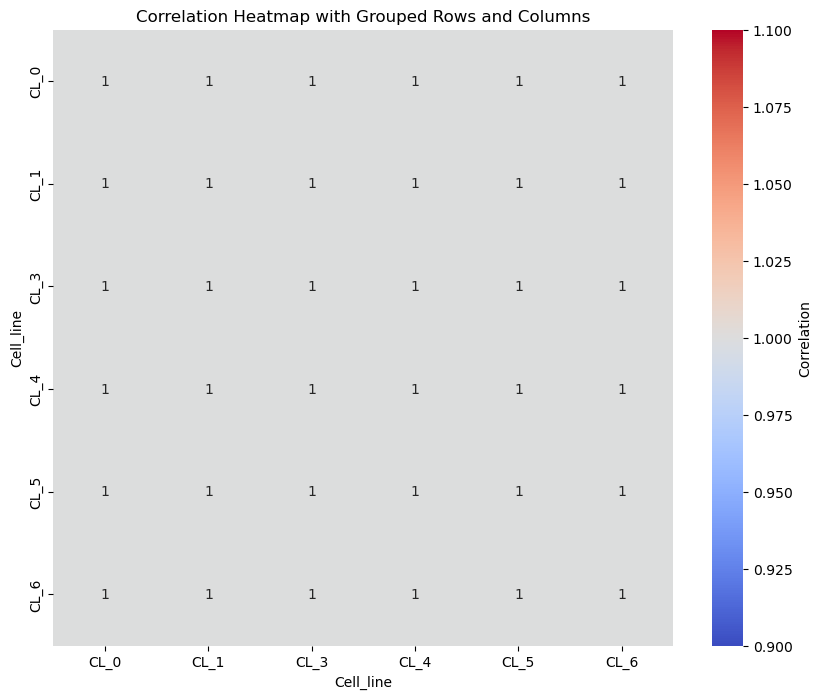

In [9]:
synthetic_data_long = synthetic_data.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')
pivot_data = synthetic_data_long.pivot_table(index=['Drug', 'Time', 'Signaling Node'], columns='Cell_line', values='Value').reset_index()

# Calculate Pearson correlation for each pair of cell lines
cell_lines = pivot_data.columns[3:]  # Skip the first three columns (Drug, Time, Signaling Node)
corr_data = pandas.DataFrame(index=cell_lines, columns=cell_lines)

for cell_line1 in cell_lines:
    for cell_line2 in cell_lines:
        if cell_line1 != cell_line2:
            corr, _ = pearsonr(pivot_data[cell_line1], pivot_data[cell_line2])
            corr_data.loc[cell_line1, cell_line2] = round(corr, 2)
        else:
            corr_data.loc[cell_line1, cell_line2] = 1.0

display(corr_data)
corr_data = corr_data.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap with Grouped Rows and Columns')
plt.show()

In [3]:
'''# Setup parameters
N = 100
inputAmplitude = 3
projectionAmplitude = 1.2
seed = 123
torch.manual_seed(seed)
numpy.random.seed(seed)

# Cell type spliting parameters
n_celllines = 6
celltype_percent = 0.2
split_1 = 2
split_2 = 2
split_3 = 2

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('data/KEGGnet-Model.tsv')
annotation = pandas.read_csv('data/KEGGnet-Annotation.tsv', sep='\t')
bionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

synthetic_data_combined = []
X_combined = []
b_celltype = pandas.DataFrame()
b_celltype_list = []

# Generate data for 6 different cell lines
# Calculate cell line specific biases
cnt = 0  # cell line counter
# Generate first gen
for j in range(split_1):
    celltype = cnt
    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = None, b_celltype = None)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

    # Generate data
    torch.manual_seed(123)
    X = torch.zeros(N, len(inName), dtype=torch.double)
    for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
        X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
        X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

    Y, YfullRef, fullYFull, b_celltype_array_1 = parameterizedModel(X)

    # Generate second gen
    for k in range(split_2):
        celltype = cnt
        parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = b_celltype_array_1, b_celltype = None)
        parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

        # Generate data
        torch.manual_seed(123)
        X = torch.zeros(N, len(inName), dtype=torch.double)
        for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
            X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
            X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

        Y, YfullRef, fullYFull, b_celltype_array_2 = parameterizedModel(X)
        # Generate third gen
        for l in range(split_3):
            cell_line_name = f"CL_{cnt}"
            celltype = cnt
            parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = b_celltype_array_2, b_celltype = None)
            parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

            # Generate data
            torch.manual_seed(123)
            X = torch.zeros(N, len(inName), dtype=torch.double)
            for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
                X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
                X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

            Y, YfullRef, fullYFull, b_celltype_array = parameterizedModel(X)
            YfullRef = YfullRef.detach()

            bias = 1e-3 * torch.ones(b_celltype_array.shape, dtype=torch.double)
            b_celltype_array = activationFunctions.MMLInvActivation(YfullRef).T - bias.detach().numpy()
            b_celltype_list.append(b_celltype_array)
            
            cnt += 1


# Create cell lines with pre-calculated bias
cnt = 0
for bias in b_celltype_list:
    cell_line_name = f"CL_{cnt}"
    celltype = cnt
    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_percent=celltype_percent, b_celltype_old = None, b_celltype = bias)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

    # Generate data
    torch.manual_seed(123)
    numpy.random.seed(123)
    X = torch.zeros(N, len(inName), dtype=torch.double)
    for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
        X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
        X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)
        
    Y, YfullRef, fullYFull, b_celltype_array = parameterizedModel(X)
    fullYFull = fullYFull.detach()

    # Transform fullYFull to a dataframe
    fullYFull_np = fullYFull.numpy()  # dimensions: conditions, node names, states

    dim1, dim2, dim3 = fullYFull_np.shape

    reshaped_array = fullYFull_np.reshape(dim1 * dim2, dim3)

    synthetic_data = pandas.DataFrame(reshaped_array)

    drug_names = ['DMSO'] + [f"D_{i}" for i in range(1, dim1)]
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name], nodeNames], names=['Drug', 'Cell_line', 'Signaling Node'])
    synthetic_data.index = index

    synthetic_data_combined.append(synthetic_data)
            
    # Transform X to a dataframe
    X = X.numpy()
    X = pandas.DataFrame(X)
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name]], names=['Drug', 'Cell_line'])
    X.index = index
    X.columns = inName
    X_combined.append(X)
            
    cnt += 1
                    
synthetic_data = pandas.concat(synthetic_data_combined)
X = pandas.concat(X_combined)

# Randomly sub-sample the cell lines
selected_cell_lines = ['CL_0', 'CL_1', 'CL_3', 'CL_4', 'CL_5', 'CL_6']
synthetic_data = synthetic_data[synthetic_data.index.get_level_values('Cell_line').isin(selected_cell_lines)]
X = X[X.index.get_level_values('Cell_line').isin(selected_cell_lines)]

display(synthetic_data.head())
display(X.head())'''

'# Setup parameters\nN = 100\ninputAmplitude = 3\nprojectionAmplitude = 1.2\nseed = 123\ntorch.manual_seed(seed)\nnumpy.random.seed(seed)\n\n# Cell type spliting parameters\nn_celllines = 6\ncelltype_percent = 0.2\nsplit_1 = 2\nsplit_2 = 2\nsplit_3 = 2\n\n# Load network\nnetworkList, nodeNames, modeOfAction = bionetwork.loadNetwork(\'data/KEGGnet-Model.tsv\')\nannotation = pandas.read_csv(\'data/KEGGnet-Annotation.tsv\', sep=\'\t\')\nbionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)\n\ninName = annotation.loc[annotation[\'ligand\'],\'code\'].values\noutName = annotation.loc[annotation[\'TF\'],\'code\'].values\ninName = numpy.intersect1d(nodeNames, inName)\noutName = numpy.intersect1d(nodeNames, outName)\n\nsynthetic_data_combined = []\nX_combined = []\nb_celltype = pandas.DataFrame()\nb_celltype_list = []\n\n# Generate data for 6 different cell lines\n# Calculate cell line specific biases\ncnt = 0  # cell line counter\n# Generate first gen\nfor j in 

In [4]:
# Check if control is properly created with all columns 0 in X
filtered_rows = X.loc['DMSO']
all_zeros = (filtered_rows == 0).all().all()
print("All columns of the rows with Drug 'DMSO' (control) are all zeros:", all_zeros)

All columns of the rows with Drug 'DMSO' (control) are all zeros: True


## Sub-sample synthetic data

Sub-sample `fullYFull` by keeping only the # most variant Drugs across Cell lines and the first 18 time points with step 3 (to ensure we reached the steady state). Select the same Conditions for `X`.

In [3]:
'''
# Select time points
num_timesteps = 150  # Number of all time steps
num_samples = 7  # Target number of time steps
exponential_indices = numpy.logspace(0, numpy.log10(num_timesteps - 1), num=num_samples, dtype=int)
print(f'Subsampled time steps: {exponential_indices}')
exponential_indices = numpy.unique(exponential_indices)
exponential_indices[0] = 0
synthetic_data_filtered = synthetic_data.iloc[:, exponential_indices]
'''
# Simple manual sampling
n_timepoints = 24
time_step = 3
synthetic_data_filtered = synthetic_data.iloc[:, :n_timepoints:time_step]

n_drugs = 7  # Number of drugs other than control

# Calculate the standard deviation for each condition to keep the ones with the heighest
synthetic_data_singlecellline = synthetic_data_filtered.xs('CL_0', level='Cell_line')
variation = synthetic_data_singlecellline.groupby('Drug').apply(lambda df: df.var(axis=1))
drug_scores = variation.groupby('Drug').mean()

top_conditions = drug_scores.nlargest(n_drugs).index
top_conditions = top_conditions.append(pandas.Index(['DMSO']))  # Add control + n_drugs drugs

synthetic_data_filtered = synthetic_data_filtered.loc[top_conditions]
synthetic_data = synthetic_data.loc[top_conditions]
display(synthetic_data_filtered.head())
display(synthetic_data.head())

# Select the same Conditions for X
unique_conditions = synthetic_data_filtered.index.get_level_values('Drug').unique()
X_filtered = X.loc[unique_conditions]
display(X_filtered.head())

# Create X_cell based on the sample cell lines
cell_lines = X_filtered.index.get_level_values('Cell_line').unique()
X_cell = pandas.DataFrame(0, index=X_filtered.index, columns=cell_lines)

for cell_line in cell_lines:
    X_cell[cell_line] = (X_filtered.index.get_level_values('Cell_line') == cell_line).astype(int)

display(X_cell.head())

0         3         6         9   \
Drug Cell_line Signaling Node                                               
D_47 CL_0      O00206         -5.585427e-05 -0.000056 -0.000015 -0.000015   
               O14492          2.172743e-02  0.020825  0.020825  0.020825   
               O14511          1.147115e-02  0.011471  0.011471  0.011471   
               O14640         -3.048172e-04 -0.000306 -0.000306 -0.000306   
               O14727          5.414221e-07  0.000001  0.000002  0.000002   

                                     12        15        18        21  
Drug Cell_line Signaling Node                                          
D_47 CL_0      O00206         -0.000015 -0.000015 -0.000015 -0.000015  
               O14492          0.020825  0.020825  0.020825  0.020825  
               O14511          0.011471  0.011471  0.011471  0.011471  
               O14640         -0.000306 -0.000306 -0.000306 -0.000306  
               O14727          0.000002  0.000002  0.000002  0.000002

0             1             2    \
Drug Cell_line Signaling Node                                             
D_47 CL_0      O00206         -5.585427e-05 -5.743208e-05 -5.724134e-05   
               O14492          2.172743e-02  2.082521e-02  2.082522e-02   
               O14511          1.147115e-02  1.147115e-02  1.147115e-02   
               O14640         -3.048172e-04 -3.077264e-04 -3.062161e-04   
               O14727          5.414221e-07  5.544846e-07  5.544872e-07   

                                    3         4         5         6    \
Drug Cell_line Signaling Node                                           
D_47 CL_0      O00206         -0.000056 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727          0.000001  0.000001  0.000001  0.000002   

                                    7         8         9    ...       140  \
Drug Cell_line Signaling Node                                ...             
D_47 CL_0      O00206         -0.000015 -0.000015 -0.000015  ... -0.000015   
               O14492          0.020825  0.020825  0.020825  ...  0.020825   
               O14511          0.011471  0.011471  0.011471  ...  0.011471   
               O14640         -0.000306 -0.000306 -0.000306  ... -0.000306   
               O14727          0.000001  0.000002  0.000002  ...  0.000002   

                                    141       142       143       144  \
Drug Cell_line Signaling Node                                           
D_47 CL_0      O00206         -0.000015 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727          0.000002  0.000002  0.000002  0.000002   

                                    145       146       147       148  \
Drug Cell_line Signaling Node                                           
D_47 CL_0      O00206         -0.000015 -0.000015 -0.000015 -0.000015   
               O14492          0.020825  0.020825  0.020825  0.020825   
               O14511          0.011471  0.011471  0.011471  0.011471   
               O14640         -0.000306 -0.000306 -0.000306 -0.000306   
               O14727          0.000002  0.000002  0.000002  0.000002   

                                    149  
Drug Cell_line Signaling Node            
D_47 CL_0      O00206         -0.000015  
               O14492          0.020825  
               O14511          0.011471  
               O14640         -0.000306  
               O14727          0.000002  

[5 rows x 150 columns]

O14511  O14788  O14944  O43557  O75093  O75094  O75326  \
Drug Cell_line                                                           
D_47 CL_0          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL_1          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL_3          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL_4          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     CL_5          0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                O94813  O96014  P00734  ...  Q8NHW4  Q8WWG1  Q96A98  Q96B86  \
Drug Cell_line                          ...                                   
D_47 CL_0          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL_1          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL_3          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL_4          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
     CL_5          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

                Q96S42  Q99075  Q9GZV9  Q9NPF7  Q9NSA1  Q9NT99  
Drug Cell_line                                                  
D_47 CL_0          0.0     0.0     0.0     0.0     0.0     0.0  
     CL_1          0.0     0.0     0.0     0.0     0.0     0.0  
     CL_3          0.0     0.0     0.0     0.0     0.0     0.0  
     CL_4          0.0     0.0     0.0     0.0     0.0     0.0  
     CL_5          0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 101 columns]

Cell_line       CL_0  CL_1  CL_3  CL_4  CL_5  CL_6
Drug Cell_line                                    
D_47 CL_0          1     0     0     0     0     0
     CL_1          0     1     0     0     0     0
     CL_3          0     0     1     0     0     0
     CL_4          0     0     0     1     0     0
     CL_5          0     0     0     0     1     0

### Explore Synthetic Data

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


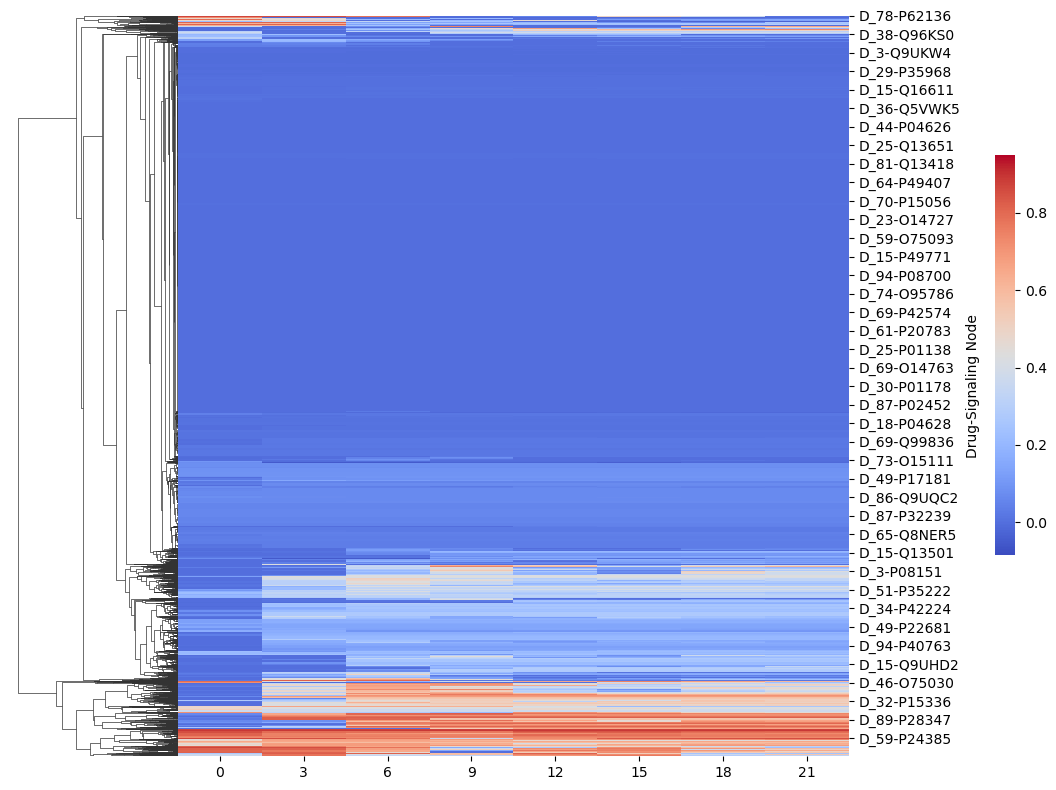

In [6]:
synthetic_data_plot = synthetic_data_filtered.copy()
annotations = synthetic_data_plot.index.to_frame(index=False)

sns.clustermap(
    synthetic_data_singlecellline, 
    cmap='coolwarm', 
    figsize=(10, 8), 
    col_cluster=False, 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()

Genes of the X dataframe that are non-0: ['P01137', 'P01374', 'P08700']


,Drug,Cell_line,Signaling Node,Time,Value
0,D_47,CL_0,P36897,0,-0.000938
1,D_47,CL_1,P36897,0,-0.000938
2,D_47,CL_3,P36897,0,-0.000938
3,D_47,CL_4,P36897,0,-0.000938
4,D_47,CL_5,P36897,0,-0.000938


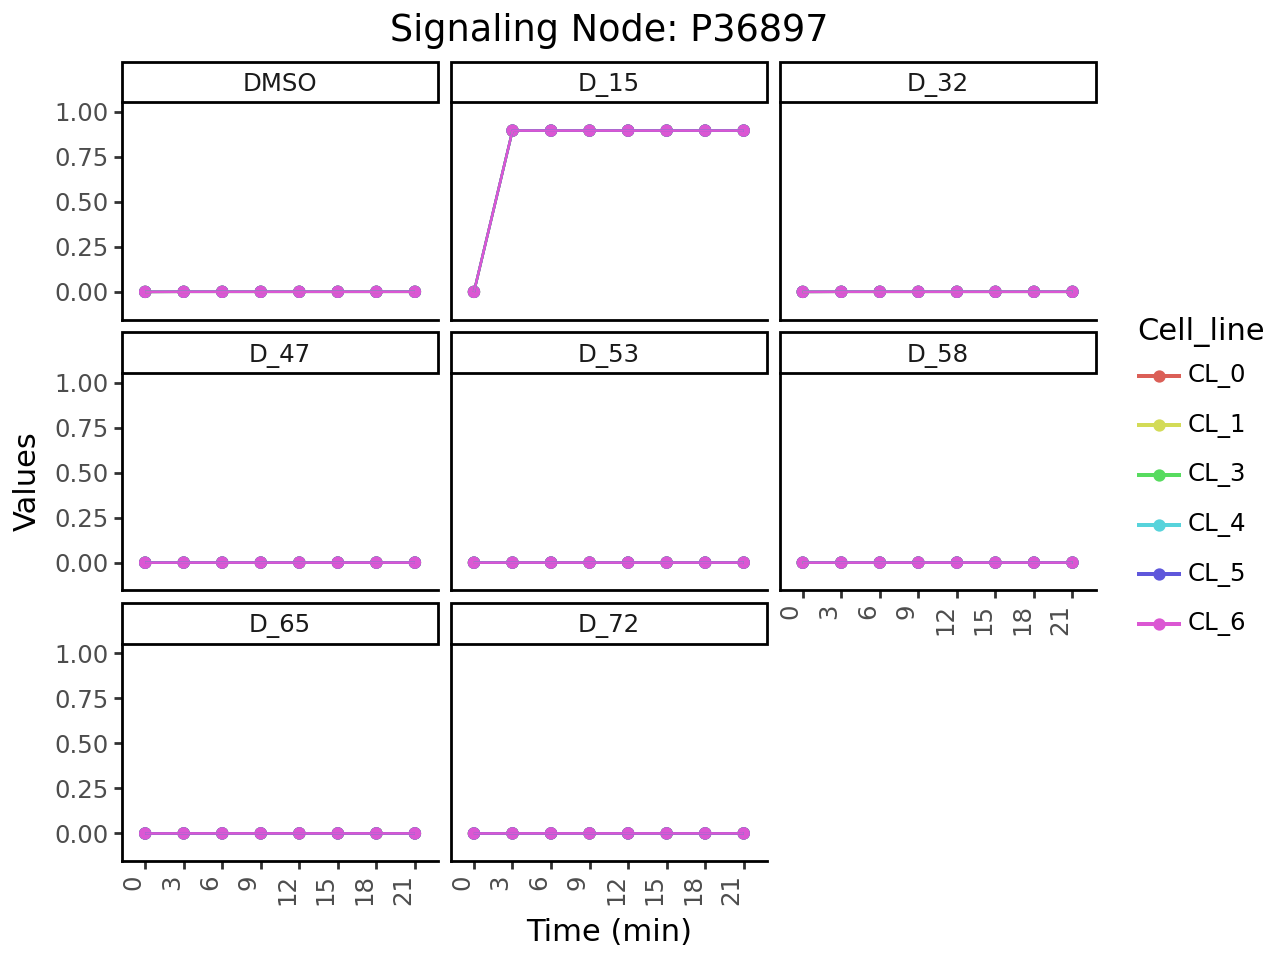

In [7]:
X_D = X.xs('D_15', level='Drug')
non_zero_columns = (X_D != 0).any(axis=0)
non_zero_column_names = non_zero_columns[non_zero_columns].index.tolist()
print(f"Genes of the X dataframe that are non-0: {non_zero_column_names}")

signaling_node = 'P36897'  #Q15796, 

idx = pandas.IndexSlice
specific_rows = synthetic_data_filtered.loc[idx[:, :, signaling_node], :]
specific_rows = specific_rows.reset_index()
specific_rows = specific_rows.melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')
display(specific_rows.head())

plot = (p9.ggplot(specific_rows, p9.aes(x='Time', y='Value', color='Cell_line', group='Cell_line'))
        + p9.geom_point()
        + p9.geom_line()
        + p9.facet_wrap('~Drug')
        + p9.labs(title=f'Signaling Node: {signaling_node}', x='Time (min)', y='Values')
        + p9.scale_y_continuous(limits=(-0.1, 1))
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)))

plot.show()

Plot the Cell line variation (correlation between average and individual cell lines).

C:\Users\kanto\AppData\Local\Temp\ipykernel_8372\823991749.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


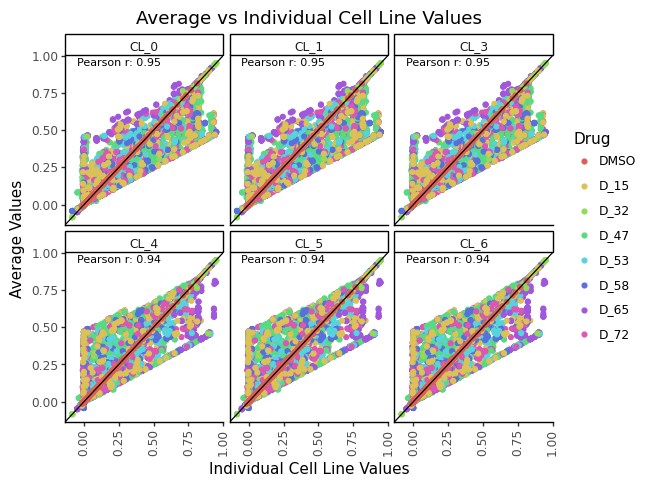

In [8]:
# Long transform the data
synthetic_data_long = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')

# Calculate the average for each Drug/Time Point/Signaling Node across all Cell Lines
average_data = synthetic_data_long.groupby(['Drug', 'Time', 'Signaling Node'])['Value'].mean().reset_index()
average_data = average_data.rename(columns={'Value': 'Average'})
merged_data = pandas.merge(synthetic_data_long, average_data, on=['Drug', 'Time', 'Signaling Node'])

# Calculate Pearson correlation for each cell line against the average
def add_pearson_corr(data):
    corr, _ = pearsonr(data['Value'], data['Average'])
    return pandas.DataFrame({'Pearson Corr': [round(corr, 2)]})

corr_data = merged_data.groupby(['Cell_line']).apply(add_pearson_corr).reset_index()

plot = (p9.ggplot(merged_data, p9.aes(x='Value', y='Average', color='Drug'))
        + p9.geom_point()
        + p9.geom_abline()
        + p9.facet_wrap('~Cell_line')
        + p9.labs(title='Average vs Individual Cell Line Values', x='Individual Cell Line Values', y='Average Values')
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=0.5))
        + p9.annotate('text', x=0.25, y=0.95, label='Pearson r: ' + corr_data['Pearson Corr'].astype(str), ha='center', va='center', size=8))

plot.draw()

Pairwise correlation between cell lines.

Cell_line,CL_0,CL_1,CL_3,CL_4,CL_5,CL_6
Cell_line,,,,,,
CL_0,1.0,1.0,1.0,0.77,0.77,0.77
CL_1,1.0,1.0,1.0,0.77,0.77,0.77
CL_3,1.0,1.0,1.0,0.77,0.77,0.77
CL_4,0.77,0.77,0.77,1.0,1.0,1.0
CL_5,0.77,0.77,0.77,1.0,1.0,1.0
CL_6,0.77,0.77,0.77,1.0,1.0,1.0


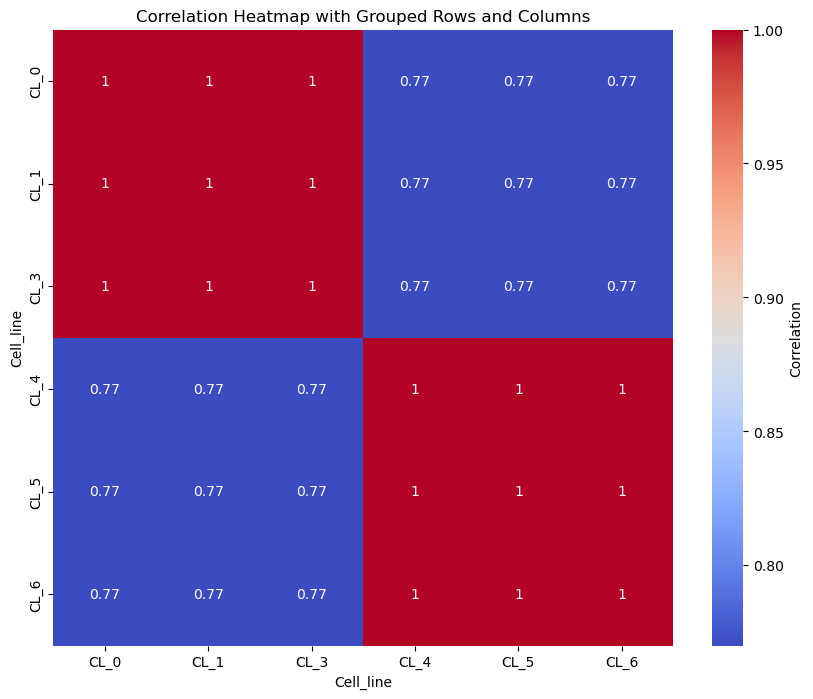

In [4]:
synthetic_data_long = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')
pivot_data = synthetic_data_long.pivot_table(index=['Drug', 'Time', 'Signaling Node'], columns='Cell_line', values='Value').reset_index()

# Calculate Pearson correlation for each pair of cell lines
cell_lines = pivot_data.columns[3:]  # Skip the first three columns (Drug, Time, Signaling Node)
corr_data = pandas.DataFrame(index=cell_lines, columns=cell_lines)

for cell_line1 in cell_lines:
    for cell_line2 in cell_lines:
        if cell_line1 != cell_line2:
            corr, _ = pearsonr(pivot_data[cell_line1], pivot_data[cell_line2])
            corr_data.loc[cell_line1, cell_line2] = round(corr, 2)
        else:
            corr_data.loc[cell_line1, cell_line2] = 1.0

display(corr_data)
corr_data = corr_data.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap with Grouped Rows and Columns')
plt.show()

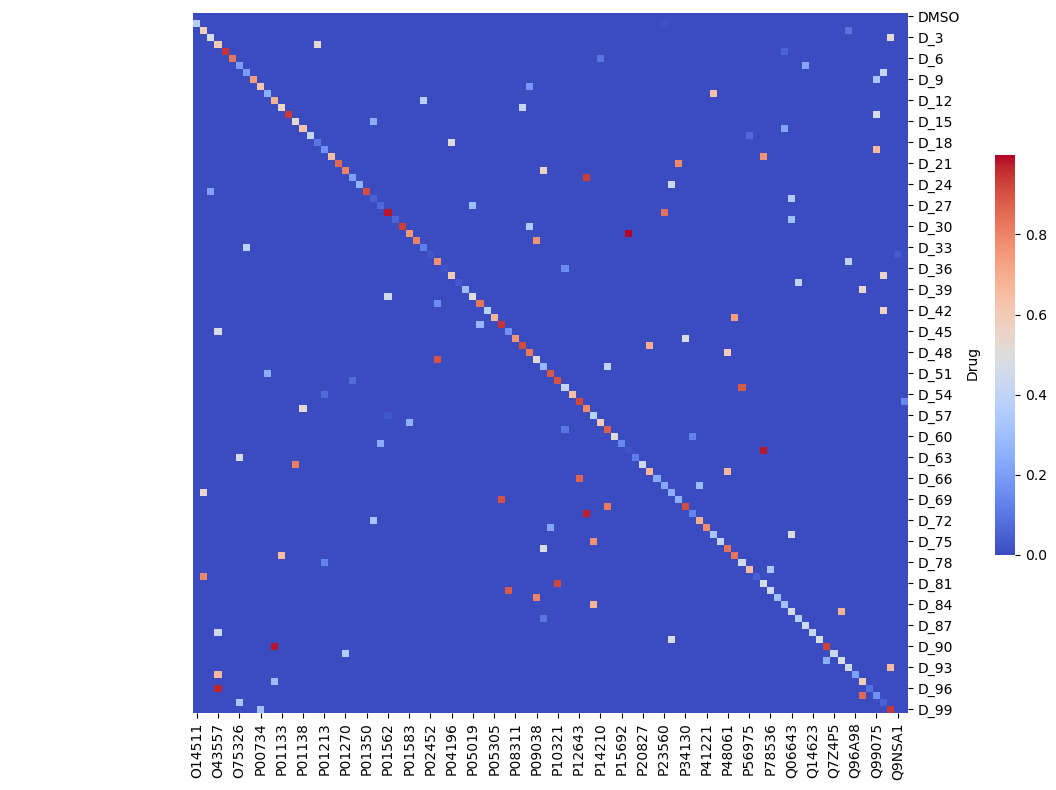

In [10]:
X_CL0 = X.xs('CL_0', level='Cell_line')
sns.clustermap(
    X_CL0, 
    cmap='coolwarm', 
    figsize=(10, 8), 
    col_cluster=False, 
    row_cluster=False,
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()

## Process Data to be Exported

Reformat `fullYFull` in order to have common Drug_CL_Time index and Genes as columns. Also, store mapping dataset (Drug_CL_Time -> Time point), so we can track which Drug_CL_Time maps to which Y time point when calculating the loss for the toy-model.

In [11]:
synthetic_data_melted = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time point', value_name='Value')
synthetic_data_melted['Drug_CL_Time'] = synthetic_data_melted['Drug'].astype(str) + '_' + synthetic_data_melted['Cell_line'].astype(str) + '_' + synthetic_data_melted['Time point'].astype(str)
synthetic_data_pivoted = synthetic_data_melted.pivot(index='Drug_CL_Time', columns='Signaling Node', values='Value')
synthetic_data_final = synthetic_data_melted[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final = synthetic_data_final.merge(synthetic_data_pivoted, left_index=True, right_index=True)

synthetic_data_melted_full = synthetic_data.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time point', value_name='Value')
synthetic_data_melted_full['Drug_CL_Time'] = synthetic_data_melted_full['Drug'].astype(str) + '_' + synthetic_data_melted_full['Cell_line'].astype(str) + '_' + synthetic_data_melted_full['Time point'].astype(str)
synthetic_data_pivoted_full = synthetic_data_melted_full.pivot(index='Drug_CL_Time', columns='Signaling Node', values='Value')
synthetic_data_final_full = synthetic_data_melted_full[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final_full = synthetic_data_final_full.merge(synthetic_data_pivoted_full, left_index=True, right_index=True)

# Create a new mapping-dataset with Drug_CL_Time and Time point
condition_time_df = synthetic_data_final[['Time point']].reset_index()

synthetic_data_final.drop(columns=['Time point'], inplace=True)  # Delete Time point column from the synthetic dataset
synthetic_data_final_full.drop(columns=['Time point'], inplace=True)

display(condition_time_df.head())
display(synthetic_data_final.head())
display(synthetic_data_final_full.head())

,Drug_CL_Time,Time point
0,D_47_CL_0_0,0
1,D_47_CL_1_0,0
2,D_47_CL_3_0,0
3,D_47_CL_4_0,0
4,D_47_CL_5_0,0


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_47_CL_0_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_1_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_3_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_4_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_5_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_47_CL_0_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_1_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_3_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_4_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_47_CL_5_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.00023,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051


In [12]:
'''# Expand X based on time
X_filtered['Condition'] = X_filtered.index
X_final = X_filtered.loc[X_filtered.index.repeat(dim3)].reset_index(drop=True)
X_final['Time point'] = numpy.tile(range(dim3), dim1)
X_final['Condition_Time'] = X_final['Condition'].astype(str) + '_' + X_final['Time point'].astype(str)
X_final.set_index('Condition_Time', inplace=True)
X_final.drop(columns=['Condition', 'Time point'], inplace=True)

X_final = X_final.loc[synthetic_data_final.index]'''
X_final = X_filtered.copy()
X_final['Drug_CL'] = X_final.index.get_level_values('Drug') + '_' + X_final.index.get_level_values('Cell_line')
X_final.set_index('Drug_CL', inplace=True)
X_final.index.name = 'Drug_CL'
display(X_final.head())

X_cell_final = X_cell.copy()
X_cell_final['Drug_CL'] = X_cell_final.index.get_level_values('Drug') + '_' + X_cell_final.index.get_level_values('Cell_line')
X_cell_final.set_index('Drug_CL', inplace=True)
X_cell_final.index.name = 'Drug_CL'
display(X_cell_final.head())

,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug_CL,,,,,,,,,,,,,,,,,,,,,
D_47_CL_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_47_CL_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_47_CL_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_47_CL_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_47_CL_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cell_line,CL_0,CL_1,CL_3,CL_4,CL_5,CL_6
Drug_CL,,,,,,
D_47_CL_0,1,0,0,0,0,0
D_47_CL_1,0,1,0,0,0,0
D_47_CL_3,0,0,1,0,0,0
D_47_CL_4,0,0,0,1,0,0
D_47_CL_5,0,0,0,0,1,0


## Simulate Missing Information

We simulate the scenario that there are genes from the PKN that are not in the synthetic data. We do that by dropping a specified percentage of random columns from the dataset. We also simulate the introduction of missing values to the synthetic dataset. A dictionary with column/variable percentages as keys and missing value percentages as values is required. Both column selection and missing value introduction is done randomly.

In [ ]:
def drop_random_columns(df, percentage):
    """
    Drop a given percentage of columns randomly from the DataFrame.
    
    Args:
        df (pandas.DataFrame): The input DataFrame.
        percentage (float): The percentage of columns to drop (between 0 and 100).
    
    Returns:
        pandas.DataFrame: The DataFrame with the specified percentage of columns dropped.
    """
    
    # Calculate the number of columns to drop and select them randomly
    num_cols_to_drop = int(len(df.columns) * (percentage / 100))
    cols_to_drop = numpy.random.choice(df.columns, num_cols_to_drop, replace=False)
    df_dropped = df.drop(columns=cols_to_drop)
    
    return df_dropped


def add_missing_values(df, missing_dict):
    """
    Add missing values to a DataFrame based on specified percentages.

    Args:
        df (pandas.DataFrame): The input DataFrame to which missing values will be added.
        missing_dict (dict): A dictionary where keys are percentages of columns to be affected,
        and values are percentages of missing values to be introduced in those columns.

    Returns:
        pandas.DataFrame: The DataFrame with missing values added.

    Raises:
        ValueError: If the sum of the keys in missing_dict exceeds 100.
    """
    numpy.random.seed(123)
    
    # Check if the keys sum up to 100
    if sum(missing_dict.keys()) < 100:
        print("Warning: The percentage of dataset columns sum up to less than 100. The rest of the dataset will remain unchanged.")
    elif sum(missing_dict.keys()) > 100:
        raise ValueError("Error: The percentage of dataset columns sum up to more than 100. Please adjust the percentages.")

    num_columns = df.shape[1]
    columns = df.columns.tolist()
    numpy.random.shuffle(columns)

    start_idx = 0
    for key, value in missing_dict.items():
        num_cols = int(num_columns * (key / 100))  # Calculate the number of columns for this percentage
        subset_columns = columns[start_idx:start_idx + num_cols]

        # Apply missing values to the subset of columns
        for col in subset_columns:
            num_missing = int(df.shape[0] * (value / 100))
            missing_indices = numpy.random.choice(df.index, num_missing, replace=False)
            df.loc[missing_indices, col] = numpy.nan

        start_idx += num_cols

    return df

print(f'Number of cols before dropping: {len(synthetic_data_final.columns)}')
#synthetic_data_final = drop_random_columns(synthetic_data_final, 30)
print(f'Number of cols after dropping: {len(synthetic_data_final.columns)}')

missing_dict = {10: 90, 30: 60, 40: 30, 20: 10}  #{100: 0}
#synthetic_data_final = add_missing_values(synthetic_data_final, missing_dict)
display(synthetic_data_final)

Number of cols before dropping: 409
Number of cols after dropping: 409


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_47_CL_0_0,NaN,0.021727,NaN,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,NaN,...,NaN,NaN,-0.000521,NaN,0.050499,NaN,NaN,-0.001756,-0.000147,0.059051
D_47_CL_1_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,NaN,NaN,-0.000018,NaN,NaN,...,NaN,0.077535,-0.000521,0.191727,0.050499,NaN,NaN,-0.001756,-0.000147,0.059051
D_47_CL_3_0,NaN,NaN,NaN,-0.000305,NaN,NaN,NaN,-0.000018,-0.004929,NaN,...,NaN,0.077535,-0.000521,NaN,0.050499,-0.000382,NaN,-0.001756,-0.000147,NaN
D_47_CL_4_0,NaN,NaN,0.011471,-0.000305,5.414221e-07,NaN,-0.000230,-0.000018,NaN,NaN,...,NaN,0.077535,NaN,0.191727,0.050499,NaN,0.025692,NaN,NaN,0.059051
D_47_CL_5_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,NaN,-0.000230,-0.000018,-0.004929,NaN,...,NaN,0.077535,-0.000521,0.191727,0.050499,NaN,NaN,-0.001756,-0.000147,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMSO_CL_1_21,NaN,0.020825,0.011471,-0.000306,NaN,-0.001564,-0.000232,NaN,-0.005034,NaN,...,NaN,0.068805,NaN,0.291000,0.050199,-0.002163,NaN,-0.002877,-0.000151,0.059037
DMSO_CL_3_21,-0.000015,0.020825,0.011471,NaN,1.342623e-06,NaN,-0.000232,NaN,-0.005034,NaN,...,NaN,NaN,0.200467,0.291000,NaN,NaN,NaN,-0.002877,-0.000151,0.059037
DMSO_CL_4_21,NaN,0.020825,0.011471,-0.000306,NaN,-0.001564,-0.000232,NaN,-0.005034,NaN,...,NaN,0.068805,NaN,0.291000,0.050199,-0.002163,NaN,-0.002877,-0.000151,NaN


## Export Data

In [14]:
synthetic_data_final.to_csv('data/synthetic_data_y.csv', index=True)
synthetic_data_final_full.to_csv('data/synthetic_data_y_full.csv', index=True)
X_final.to_csv('data/synthetic_data_x.csv', index=True)
X_cell_final.to_csv('data/synthetic_data_xcell.csv', index=True)
condition_time_df.to_csv('data/synthetic_data_xtime.csv', index=True)
b_celltype.to_csv('data/b_celltype.csv', index=True)